In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
from keras.initializers import RandomNormal

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Load data

### Webcam dataset

In [40]:
X_raw = np.load("data/images.npy")
y = np.load("data/labels.npy")
y = [val[0] for val in y]

X = []
for x in X_raw:
    X.append(preprocess_input(x))
    
del X_raw
    
X = np.asarray(X)
y = np.asarray(y)

# train test split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state = 123)

# validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 123)

del X,y

### Shanghai tech B and density maps

### Train:

In [2]:
Train_imgs_B = []
Train_density_B = []
Train_labels_B = []

path_images = "./data/ShanghaiTech/part_B/train_data/images/"
path_heads = "./data/ShanghaiTech/part_B/train_data/ground-truth/"
path_maps = "./data/ShanghaiTech/part_B/train_data/maps/"

for img_name, den_name, heads_name in zip(os.listdir(path = path_images), os.listdir(path = path_maps), os.listdir(path = path_heads)):   
    
    Train_imgs_B.append(preprocess_input(cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB)))
    Train_density_B.append(np.load(path_maps + den_name))
    Train_labels_B.append(len(loadmat(path_heads + heads_name)['image_info'][0, 0][0, 0][0]))
    
# Train_imgs_B = np.asarray(Train_imgs_B)
# Train_density_B = np.asarray(Train_density_B)
# Train_labels_B = np.asarray(Train_labels_B)

### Test:

In [3]:
Test_imgs_B = []
Test_density_B = []
Test_labels_B = []

path_images = "./data/ShanghaiTech/part_B/test_data/images/"
path_heads = "./data/ShanghaiTech/part_B/test_data/ground-truth/"
path_maps = "./data/ShanghaiTech/part_B/test_data/maps/"

for img_name, den_name, heads_name in zip(os.listdir(path = path_images), os.listdir(path = path_maps), os.listdir(path = path_heads)):   
    
    Test_imgs_B.append(preprocess_input(cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB)))
    Test_density_B.append(np.load(path_maps + den_name))
    Test_labels_B.append(len(loadmat(path_heads + heads_name)['image_info'][0, 0][0, 0][0]))
    
# Test_imgs_B = np.asarray(Test_imgs_B)
# Test_density_B = np.asarray(Test_density_B)
# Test_labels_B = np.asarray(Test_labels_B)

## Build the model

In [4]:
VGG_16 = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

In [5]:
VGG_16 = Model(VGG_16.input, VGG_16.layers[-6].output)

for layer in VGG_16.layers[:]:
    layer.trainable = False


Map_estimator_net = Sequential([
            Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01))
            ])(VGG_16.output)

CSRnet = Model(inputs=VGG_16.input, outputs=Map_estimator_net)
CSRnet.compile(optimizer=SGD(lr = 1e-6, decay = (5*1e-4), momentum = 0.9), loss = "mse", metrics=["mae"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

I use the last 50 images of the train set as validation set

# Test models

## Shanghai tech B

In [27]:
def test_model_stB(file_parameters_path):   
    CSRnet.load_weights(file_parameters_path)

    error = 0
    N = len(Test_labels_B)
    for i, (x, y) in enumerate(zip(Test_imgs_B, Test_labels_B)):
        if i % 10 == 0: 
            print("                                                        ", end = '\r')
            print(f"{round(i/N,2) * 100}% of predictions done", end = '\r')

        error += np.abs(np.sum(CSRnet.predict(np.reshape(np.asarray(x),(1,x.shape[0],x.shape[1],x.shape[2])))) - y)
    
    print()
    return error/N

In [23]:
file_parameters_path = "./trained_models/csrnet/csrnet_model_frozen.h5"
mae_frozen = test_model_stB(file_parameters_path)

print(mae_frozen)

40.16773975046375


In [28]:
file_parameters_path = "./trained_models/csrnet/csrnet_model_unfrozen.h5"
mae_unfrozen = test_model_stB(file_parameters_path)
print(mae_unfrozen)

98.0% of predictions done                               
28.345644151108175


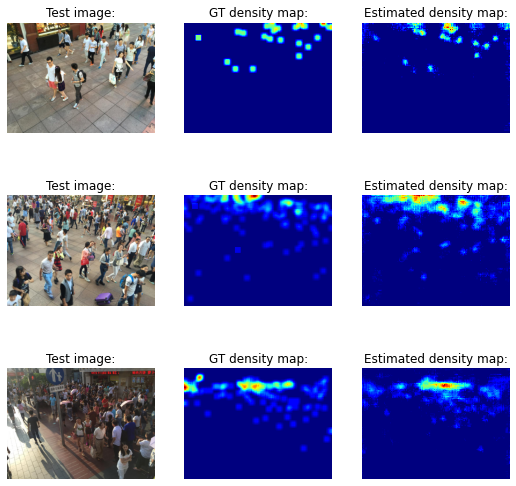

In [39]:
to_print = 3
plt.figure(figsize=(9, 3 * to_print))

for i, (img, dens, raw) in enumerate(zip(Test_imgs_B, Test_density_B, os.listdir(path = path_images))):   
    if i == to_print: break
        
    estimated_dens = CSRnet.predict(np.reshape(np.asarray(img),(1,img.shape[0],img.shape[1],img.shape[2])))
    
    plt.subplot(to_print, 3, i * 3 + 1)
    plt.axis("off")
    plt.title("Test image:")
    plt.imshow(cv2.cvtColor(cv2.imread(path_images + raw), cv2.COLOR_BGR2RGB))
    
    plt.subplot(to_print, 3, i * 3 + 2)
    plt.axis("off")
    plt.title("GT density map:")
    plt.imshow(dens , cmap = cm.jet)
    
    
    plt.subplot(to_print, 3, i * 3 + 3)
    plt.axis("off")
    plt.title("Estimated density map:")
    plt.imshow(estimated_dens.reshape((estimated_dens.shape[1], estimated_dens.shape[2], 1)) , cmap = cm.jet)

## Webcam

In [41]:
def test_model_webcam(file_parameters_path):   
    CSRnet.load_weights(file_parameters_path)

    error = 0
    N = len(y_test)
    for i, (x, y) in enumerate(zip(X_test, y_test)):
        if i % 10 == 0: 
            print("                                                        ", end = '\r')
            print(f"{round(i/N,2) * 100}% of predictions done", end = '\r')

        error += np.abs(np.sum(CSRnet.predict(np.reshape(np.asarray(x),(1,x.shape[0],x.shape[1],x.shape[2])))) - y)
    
    print()
    return error/N

In [45]:
mae_frozen_webcam = test_model_webcam("./trained_models/csrnet/csrnet_model_frozen.h5")
print(mae_frozen_webcam)

14.338724996470198


In [44]:
mae_unfrozen_webcam = test_model_webcam("./trained_models/csrnet/csrnet_model_unfrozen.h5")
print(mae_unfrozen_webcam)

12.627440202085278
